In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # For LogNorm

sns.set_theme(style="whitegrid")

In [ ]:
RUN_DIR = Path("/lotterlab/users/abdul/repos/chipvi/runs/rp_info_loss")

In [4]:
import torch
import torch.distributions as dist
from tqdm import tqdm
def run_analysis(data_dir):
    def load_val_data(epoch):
        val_mu_tech_r1 = np.load(data_dir / f'val_mu_tech_val_r1_{epoch}.npy')
        val_mu_tech_r2 = np.load(data_dir / f'val_mu_tech_val_r2_{epoch}.npy')
        val_mu1_r1_diff = np.load(data_dir / f'val_mu1_r1_diff_{epoch}.npy')
        val_mu1_r2_diff = np.load(data_dir / f'val_mu2_r2_diff_scaled_{epoch}.npy')
        val_yi_r1 = np.load(data_dir / f'val_y_i_val_r1_{epoch}.npy')
        val_yi_r2 = np.load(data_dir / f'val_y_i_val_r2_{epoch}.npy')
        try:
            val_r_r1 = np.load(data_dir / f'val_r1_tech_val_r1_{epoch}.npy')
            val_r_r2 = np.load(data_dir / f'val_r2_tech_val_r2_{epoch}.npy')
        except FileNotFoundError:
            val_r_r1 = None
            val_r_r2 = None
        try:
            val_xi_r1 = np.load(data_dir / f'val_xi_val_r1.npy')
            val_xi_r1 = pd.DataFrame(val_xi_r1)
            val_xi_r1.columns = ["ctrl_reads_r1", "ctrl_mapq_r1", "ctrl_sd_r1", "exp_mapq_r1", "exp_sd_r1"]
            val_xi_r2 = pd.DataFrame(np.load(data_dir / f'val_xi_val_r2.npy'))
            val_xi_r2.columns = ["ctrl_reads_r2", "ctrl_mapq_r2", "ctrl_sd_r2", "exp_mapq_r2", "exp_sd_r2"]
            x_vals = pd.concat([val_xi_r1, val_xi_r2], axis=1)
        except FileNotFoundError:
            x_vals = None


        df = pd.DataFrame({ 
            'mu_tech_r1': val_mu_tech_r1,
            'mu_tech_r2': val_mu_tech_r2,
            'mu1_r1_diff': val_mu1_r1_diff,
            'mu2_r2_diff': val_mu1_r2_diff,
            'yi_r1': val_yi_r1,
            'yi_r2': val_yi_r2
        })
        if val_r_r1 is not None:
            df['r_r1'] = val_r_r1
            df['r_r2'] = val_r_r2
        if x_vals is not None:
            df = pd.concat([df, x_vals], axis=1)

        # Define Poisson distribution
        device = torch.device("cuda:0")
        r1_quantiles = []
        r2_quantiles = []
        for i in np.arange(0, len(df), 10_000):
            stop = min(i + 10_000, len(df))
            r1_quantiles += poisson_cdf(torch.tensor([df["yi_r1"].values[i:stop]]).to(device), torch.tensor([df["mu_tech_r1"].values[i:stop]]).to(device)).cpu().numpy().flatten().tolist()
            r2_quantiles += poisson_cdf(torch.tensor([df["yi_r2"].values[i:stop]]).to(device), torch.tensor([df["mu_tech_r2"].values[i:stop]]).to(device)).cpu().numpy().flatten().tolist()

        df["quantile_r1"] = r1_quantiles
        df["quantile_r2"] = r2_quantiles

        return df

    epoch_dfs = []
    for i in tqdm(range(100)):
        try:
            epoch_dfs.append(load_val_data(i))
            print(f"Loaded epoch {i}")
        except FileNotFoundError:
            break
    
    fig, ax = plt.subplots()

    biol_corrs = [np.corrcoef(df["mu1_r1_diff"], df["mu2_r2_diff"])[0][1] for df in epoch_dfs]
    biol_corrs_clipped = [np.corrcoef(df["mu1_r1_diff"].clip(lower=0, upper=None), df["mu2_r2_diff"].clip(lower=0, upper=None))[0][1] for df in epoch_dfs]
    tech_corrs = [np.corrcoef(df["mu_tech_r1"], df["mu_tech_r2"])[0][1] for df in epoch_dfs]
    raw_corrs = [np.corrcoef(df["yi_r1"], df["yi_r2"])[0][1] for df in epoch_dfs]
    quantile_corrs = [np.corrcoef(df["quantile_r1"], df["quantile_r2"])[0][1] for df in epoch_dfs]
    tech_raw_r1_corrs = [np.corrcoef(df["mu_tech_r1"], df["yi_r1"])[0][1] for df in epoch_dfs]
    tech_raw_r2_corrs = [np.corrcoef(df["mu_tech_r2"], df["yi_r2"])[0][1] for df in epoch_dfs]

    ax.plot(biol_corrs, label="biological correlation", marker="o")
    ax.plot(biol_corrs_clipped, label="biological correlation (clipped)", marker="o")
    ax.plot(tech_corrs, label="technical correlation", marker="o")
    ax.plot(raw_corrs, label="raw correlation", marker="o")
    ax.plot(quantile_corrs, label="quantile correlation", marker="o")
    ax.plot(tech_raw_r1_corrs, label="technical vs raw (r1)", marker="o")
    ax.plot(tech_raw_r2_corrs, label="technical vs raw (r2)", marker="o")

    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("correlation")
    ax.set_title("Correlation over training")

    return epoch_dfs

In [ ]:
r2_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_2"))
r2_dfs[-1]

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,quantile_r1,quantile_r2
0,1.654078,1.453390,0.345922,2.746184,2.0,3.0,0.769294,0.940071
1,1.654078,1.453390,0.345922,0.970569,2.0,2.0,0.769294,0.820453
2,1.776421,1.555970,-0.776421,-0.987188,1.0,1.0,0.507641,0.573545
3,2.442062,2.192069,-1.442062,-3.892270,1.0,0.0,0.507641,0.233776
4,2.442062,2.192081,-0.442062,-2.116676,2.0,1.0,0.769294,0.573545
...,...,...,...,...,...,...,...,...
1673979,1.528662,1.136107,1.471338,1.065872,3.0,2.0,0.892426,0.864770
1673980,1.528664,1.136107,1.471336,1.065871,3.0,2.0,0.892426,0.864770
1673981,1.528666,1.136107,1.471334,1.065871,3.0,2.0,0.892426,0.864770
1673982,1.528664,1.136109,1.471336,1.065869,3.0,2.0,0.892426,0.864770


100%|██████████| 168/168 [00:01<00:00, 106.40it/s]


Loaded epoch 0


100%|██████████| 168/168 [00:01<00:00, 124.81it/s]


Loaded epoch 1


100%|██████████| 168/168 [00:01<00:00, 106.26it/s]


Loaded epoch 2


100%|██████████| 168/168 [00:01<00:00, 107.42it/s]


Loaded epoch 3


100%|██████████| 168/168 [00:01<00:00, 108.10it/s]


Loaded epoch 4


100%|██████████| 168/168 [00:01<00:00, 122.31it/s]


Loaded epoch 5


100%|██████████| 168/168 [00:01<00:00, 126.04it/s]


Loaded epoch 6


100%|██████████| 168/168 [00:01<00:00, 136.41it/s]


Loaded epoch 7


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,quantile_r1,quantile_r2
0,1.777783,1.602351,0.222217,2.481687,2.0,3.0,0.736563,0.920862
1,1.777783,1.602351,0.222217,0.706072,2.0,2.0,0.736563,0.782751
2,1.854420,1.668559,-0.854420,-1.187104,1.0,1.0,0.469480,0.524172
3,2.203969,2.000801,-1.203969,-3.552653,1.0,0.0,0.469480,0.201422
4,2.203969,2.000790,-0.203969,-1.777017,2.0,1.0,0.736563,0.524172
...,...,...,...,...,...,...,...,...
1673979,1.705096,1.377298,1.294904,0.768290,3.0,2.0,0.876929,0.818879
1673980,1.705079,1.377295,1.294921,0.768293,3.0,2.0,0.876929,0.818879
1673981,1.705062,1.377293,1.294938,0.768295,3.0,2.0,0.876929,0.818879
1673982,1.705072,1.377274,1.294928,0.768319,3.0,2.0,0.876929,0.818879


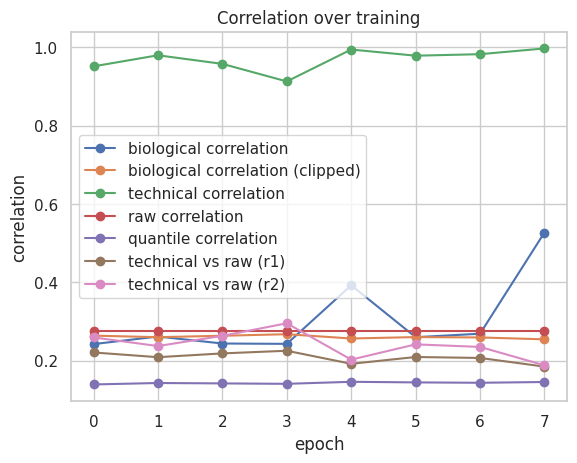

In [8]:
h3k_ll_only_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_joint_ll_only"))
plot_df_2d_hist(h3k_ll_only_dfs[-1])
h3k_ll_only_dfs[-1]

100%|██████████| 176/176 [00:01<00:00, 101.01it/s]


Loaded epoch 0


100%|██████████| 176/176 [00:01<00:00, 130.22it/s]


Loaded epoch 1


100%|██████████| 176/176 [00:01<00:00, 103.47it/s]


Loaded epoch 2


100%|██████████| 176/176 [00:01<00:00, 106.08it/s]


Loaded epoch 3


100%|██████████| 176/176 [00:01<00:00, 136.60it/s]


Loaded epoch 4


100%|██████████| 176/176 [00:02<00:00, 80.09it/s]


Loaded epoch 5


100%|██████████| 176/176 [00:01<00:00, 108.19it/s]


Loaded epoch 6


100%|██████████| 176/176 [00:01<00:00, 154.67it/s]


Loaded epoch 7
Subsampling dataframe from 1,756,160 to 200,000 rows for plotting speed.

Outlier removal for columns ['yi_r1', 'yi_r2']:
  • yi_r1        kept range [1.000, 18.000]
  • yi_r2        kept range [0.000, 27.000]
  → Dropped 1,624 / 200,000 rows (0.81%)
  → Remaining: 198,376 rows


Outlier removal for columns ['mu_tech_r1', 'mu_tech_r2']:
  • mu_tech_r1   kept range [1.443, 6.852]
  • mu_tech_r2   kept range [1.665, 16.756]
  → Dropped 1,590 / 200,000 rows (0.80%)
  → Remaining: 198,410 rows


Outlier removal for columns ['biol_r1', 'biol_r2']:
  • biol_r1      kept range [-4.427, 15.171]
  • biol_r2      kept range [-8.011, 18.690]
  → Dropped 3,393 / 200,000 rows (1.70%)
  → Remaining: 196,607 rows


Outlier removal for columns ['biol_r1_clipped', 'biol_r2_clipped']:
  • biol_r1_clipped kept range [0.000, 15.171]
  • biol_r2_clipped kept range [0.000, 18.690]
  → Dropped 1,579 / 200,000 rows (0.79%)
  → Remaining: 198,421 rows



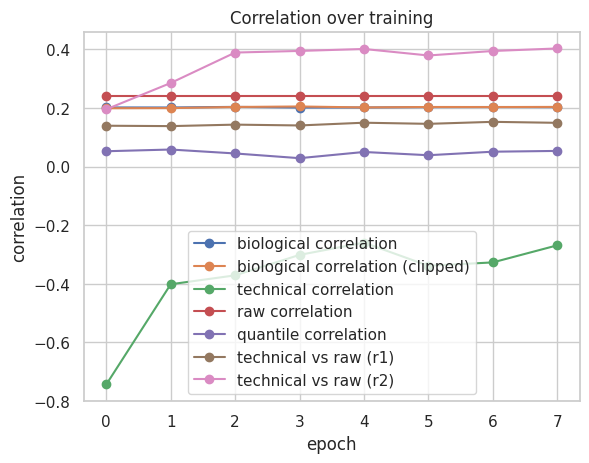

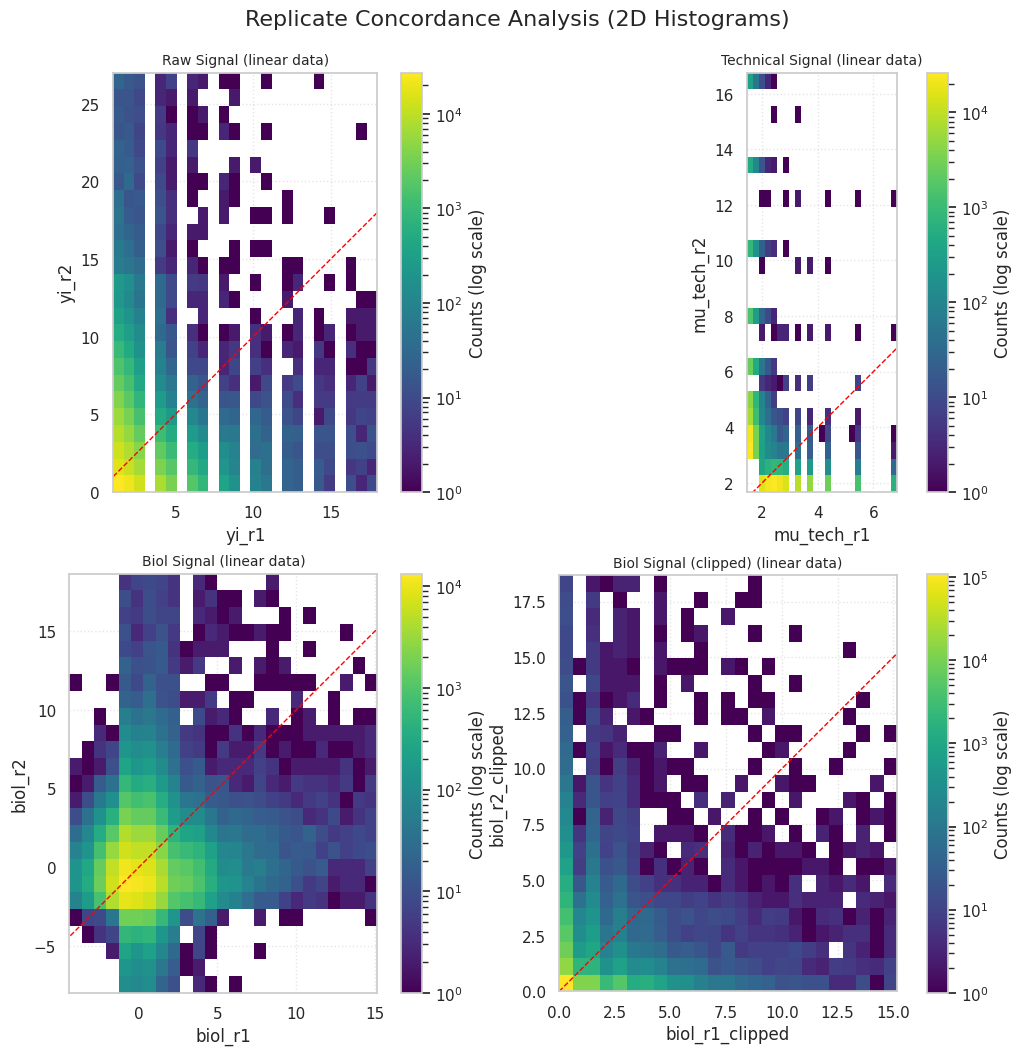

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,quantile_r1,quantile_r2
0,1.526657,3.565016,-0.526657,2.434491,1.0,4.0,0.548943,0.713115
1,1.662022,3.565016,-0.662022,-8.758976,1.0,2.0,0.548943,0.308989
2,1.905814,3.565016,-0.905814,-8.758976,1.0,2.0,0.548943,0.308989
3,1.526657,6.338813,-0.526657,-13.089715,1.0,4.0,0.548943,0.713115
4,1.526657,6.338813,0.473343,-1.896248,2.0,6.0,0.802126,0.929583
...,...,...,...,...,...,...,...,...
1756155,2.193784,2.050789,-1.193784,-1.885091,1.0,1.0,0.116751,0.456434
1756156,2.562869,2.050783,-1.562869,-0.091104,1.0,2.0,0.116751,0.724824
1756157,2.357795,1.821632,-1.357795,2.113964,1.0,3.0,0.116751,0.887792
1756158,2.829593,1.821667,-1.829593,-1.474051,1.0,1.0,0.116751,0.456434


In [11]:
ctcf_ll_only_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/ctcf/run_joint_ll_only"))
plot_df_2d_hist(ctcf_ll_only_dfs[-1])
ctcf_ll_only_dfs[-1]

100%|██████████| 168/168 [00:01<00:00, 114.47it/s]


Loaded epoch 0


100%|██████████| 168/168 [00:01<00:00, 95.86it/s] 


Loaded epoch 1


100%|██████████| 168/168 [00:01<00:00, 85.05it/s]


Loaded epoch 2


100%|██████████| 168/168 [00:01<00:00, 148.30it/s]


Loaded epoch 3


100%|██████████| 168/168 [00:01<00:00, 130.12it/s]


Loaded epoch 4


100%|██████████| 168/168 [00:02<00:00, 82.24it/s] 


Loaded epoch 5


100%|██████████| 168/168 [00:01<00:00, 134.96it/s]


Loaded epoch 6


100%|██████████| 168/168 [00:01<00:00, 116.89it/s]


Loaded epoch 7


100%|██████████| 168/168 [00:01<00:00, 123.93it/s]


Loaded epoch 8


100%|██████████| 168/168 [00:01<00:00, 110.83it/s]


Loaded epoch 9


100%|██████████| 168/168 [00:01<00:00, 117.35it/s]


Loaded epoch 10


100%|██████████| 168/168 [00:01<00:00, 88.02it/s]


Loaded epoch 11


100%|██████████| 168/168 [00:01<00:00, 127.51it/s]


Loaded epoch 12


100%|██████████| 168/168 [00:01<00:00, 142.28it/s]


Loaded epoch 13


100%|██████████| 168/168 [00:01<00:00, 96.44it/s] 


Loaded epoch 14


100%|██████████| 168/168 [00:01<00:00, 116.05it/s]


Loaded epoch 15


100%|██████████| 168/168 [00:01<00:00, 134.62it/s]


Loaded epoch 16


100%|██████████| 168/168 [00:01<00:00, 143.63it/s]


Loaded epoch 17
Subsampling dataframe from 1,673,984 to 200,000 rows for plotting speed.

Outlier removal for columns ['yi_r1', 'yi_r2']:
  • yi_r1        kept range [1.000, 7.000]
  • yi_r2        kept range [0.000, 7.000]
  → Dropped 1,371 / 200,000 rows (0.69%)
  → Remaining: 198,629 rows


Outlier removal for columns ['mu_tech_r1', 'mu_tech_r2']:
  • mu_tech_r1   kept range [1.657, 1.987]
  • mu_tech_r2   kept range [1.137, 1.668]
  → Dropped 753 / 200,000 rows (0.38%)
  → Remaining: 199,247 rows


Outlier removal for columns ['biol_r1', 'biol_r2']:
  • biol_r1      kept range [-0.956, 5.283]
  • biol_r2      kept range [-1.648, 5.421]
  → Dropped 2,858 / 200,000 rows (1.43%)
  → Remaining: 197,142 rows


Outlier removal for columns ['biol_r1_clipped', 'biol_r2_clipped']:
  • biol_r1_clipped kept range [0.000, 5.283]
  • biol_r2_clipped kept range [0.000, 5.421]
  → Dropped 1,794 / 200,000 rows (0.90%)
  → Remaining: 198,206 rows



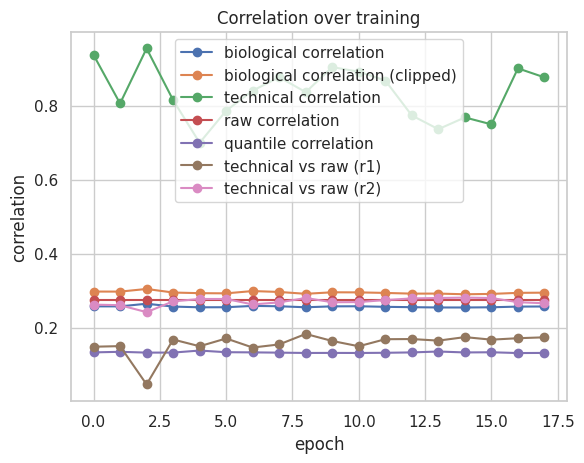

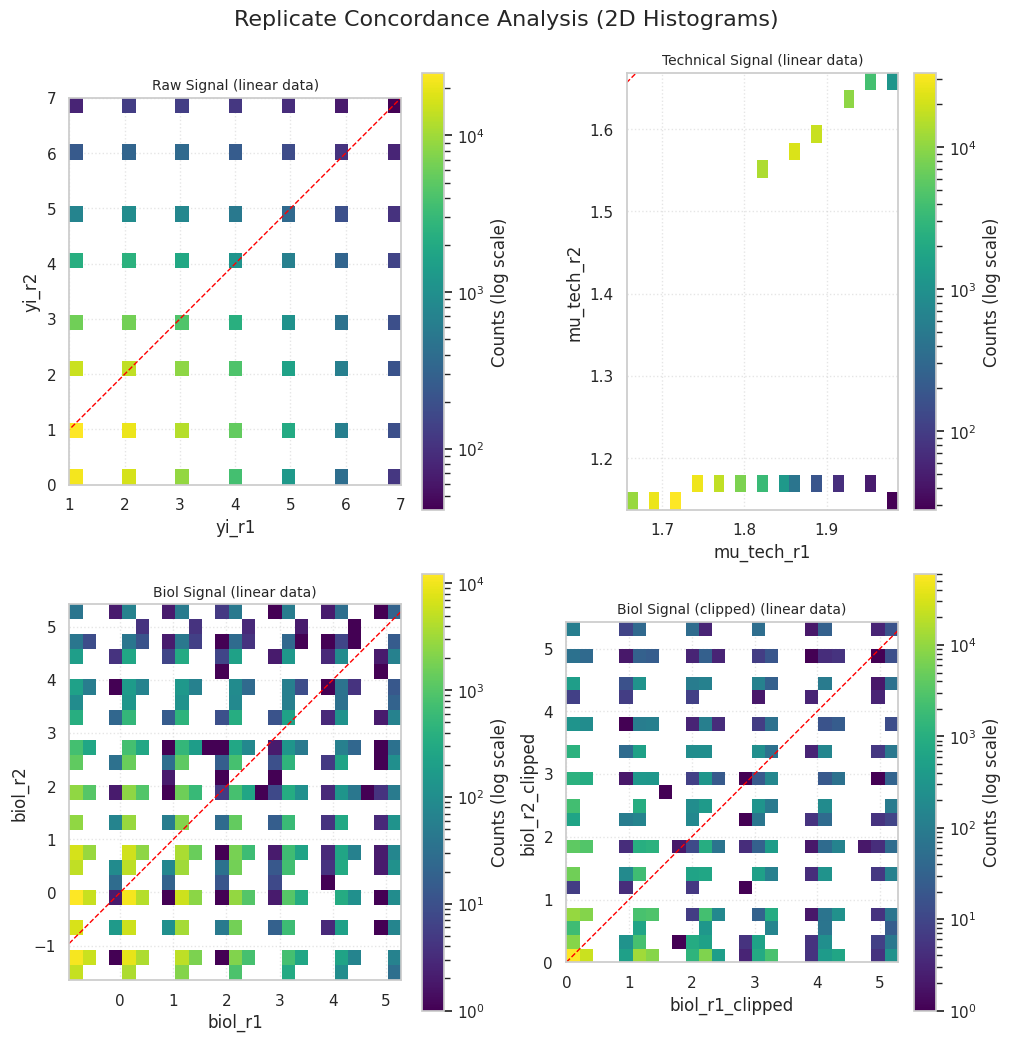

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,quantile_r1,quantile_r2
0,1.860536,1.579290,0.139464,1.420710,2.0,3.0,0.714362,0.924015
1,1.860536,1.579290,0.139464,0.420710,2.0,2.0,0.714362,0.788696
2,1.893432,1.604051,-0.893432,-0.604051,1.0,1.0,0.445069,0.531647
3,1.986520,1.668365,-0.986520,-1.668365,1.0,0.0,0.445069,0.206121
4,1.986520,1.668384,0.013480,-0.668384,2.0,1.0,0.714362,0.531647
...,...,...,...,...,...,...,...,...
1673979,1.717445,1.153218,1.282555,0.846782,3.0,2.0,0.896022,0.887504
1673980,1.717469,1.153223,1.282531,0.846777,3.0,2.0,0.896022,0.887504
1673981,1.717495,1.153226,1.282505,0.846774,3.0,2.0,0.896022,0.887504
1673982,1.717479,1.153265,1.282521,0.846735,3.0,2.0,0.896022,0.887504


In [12]:
h3k_all_3_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_all_3_no_biol_scaling"))
plot_df_2d_hist(h3k_all_3_dfs[-1])
h3k_all_3_dfs[-1]

In [22]:
np.corrcoef(h3k_all_3_dfs[-1]["yi_r1"], h3k_all_3_dfs[-1]["yi_r2"])

array([[1.        , 0.27446844],
       [0.27446844, 1.        ]])

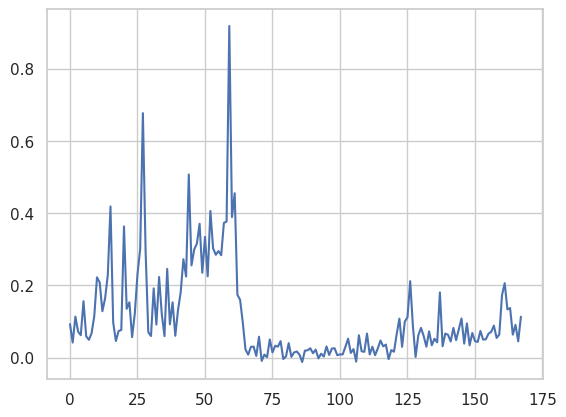

In [23]:
corrs = []
for i in np.arange(0, len(h3k_all_3_dfs[-1]), 10_000):
    stop = min(i + 10_000, len(h3k_all_3_dfs[-1]))
    corrs.append(np.corrcoef(h3k_all_3_dfs[-1]["yi_r1"][i:stop], h3k_all_3_dfs[-1]["yi_r2"][i:stop])[0][1])
plt.plot(corrs)

In [24]:
h3k_all_3_dfs[-1].iloc[550_000:551_000]

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,quantile_r1,quantile_r2
550000,1.893432,1.604051,-0.893432,0.395949,1.0,2.0,0.435618,0.782311
550001,1.893432,1.604051,0.106568,0.395949,2.0,2.0,0.705493,0.782311
550002,1.925070,1.626994,1.074930,0.373006,3.0,2.0,0.875823,0.782311
550003,1.925070,1.626994,2.074930,-0.626994,4.0,1.0,0.956450,0.523623
550004,1.925070,1.626977,1.074930,-1.626977,3.0,0.0,0.875823,0.201080
...,...,...,...,...,...,...,...,...
550995,1.860536,1.579290,1.139464,3.420711,3.0,5.0,0.875823,0.993888
550996,1.826028,1.552618,0.173972,3.447382,2.0,5.0,0.705493,0.993888
550997,1.860536,1.579290,0.139464,2.420711,2.0,4.0,0.705493,0.976094
550998,1.860536,1.579290,0.139464,2.420711,2.0,4.0,0.705493,0.976094


In [21]:
h3k_nb_all_3_dfs[-1]

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2,quantile_r1,quantile_r2
0,1.645795,1.435429,0.354205,1.564571,2.0,3.0,1.0,0.999937,1.811243,0.999937,2.002470,1.0,0.999937,1.811243,0.999937,1.775615,0.771459,0.942199
1,1.645795,1.435429,0.354205,0.564571,2.0,2.0,1.0,0.999937,1.811243,0.999937,2.002470,1.0,0.999937,1.811243,0.999937,1.775615,0.771459,0.824872
2,1.719025,1.490296,-0.719025,-0.490296,1.0,1.0,2.0,0.999937,1.811243,0.999937,2.002470,2.0,0.999937,1.811243,0.999937,1.775615,0.510266,0.579664
3,2.041274,1.756890,-1.041274,-1.756890,1.0,0.0,5.0,0.999937,1.811243,0.999937,2.002470,5.0,0.999937,1.811243,1.000000,1.775615,0.510266,0.238013
4,2.041274,1.756901,-0.041274,-0.756901,2.0,1.0,5.0,0.999937,1.811243,0.999937,2.002470,5.0,0.999937,1.811243,0.999937,1.775615,0.771459,0.579664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673979,1.617180,1.194782,1.382820,0.805218,3.0,2.0,2.0,0.999369,2.591536,0.999478,1.842645,2.0,0.999369,2.591536,0.999332,1.233800,0.899057,0.869548
1673980,1.617191,1.194784,1.382809,0.805216,3.0,2.0,2.0,0.999369,2.591536,0.999390,1.842645,2.0,0.999369,2.591536,0.999292,1.233800,0.899057,0.869548
1673981,1.617202,1.194785,1.382798,0.805215,3.0,2.0,2.0,0.999343,2.591536,0.999325,1.842645,2.0,0.999343,2.591536,0.999292,1.233800,0.899057,0.869548
1673982,1.617195,1.194801,1.382805,0.805199,3.0,2.0,2.0,0.999048,2.591536,0.999673,1.842645,2.0,0.999048,2.591536,0.999266,1.233800,0.899057,0.869548


  1%|          | 1/100 [00:03<05:12,  3.16s/it]

Loaded epoch 0


  2%|▏         | 2/100 [00:05<04:28,  2.74s/it]

Loaded epoch 1


  3%|▎         | 3/100 [00:08<04:20,  2.68s/it]

Loaded epoch 2


  4%|▍         | 4/100 [00:11<04:34,  2.86s/it]

Loaded epoch 3


Subsampling dataframe from 1,673,984 to 200,000 rows for plotting speed.

Outlier removal for columns ['yi_r1', 'yi_r2']:
  • yi_r1        kept range [1.000, 7.000]
  • yi_r2        kept range [0.000, 7.000]
  → Dropped 1,371 / 200,000 rows (0.69%)
  → Remaining: 198,629 rows


Outlier removal for columns ['mu_tech_r1', 'mu_tech_r2']:
  • mu_tech_r1   kept range [1.534, 2.178]
  • mu_tech_r2   kept range [1.166, 1.757]
  → Dropped 1,488 / 200,000 rows (0.74%)
  → Remaining: 198,512 rows


Outlier removal for columns ['biol_r1', 'biol_r2']:
  • biol_r1      kept range [-1.041, 5.412]
  • biol_r2      kept range [-1.649, 5.510]
  → Dropped 2,926 / 200,000 rows (1.46%)
  → Remaining: 197,074 rows


Outlier removal for columns ['biol_r1_clipped', 'biol_r2_clipped']:
  • biol_r1_clipped kept range [0.000, 5.412]
  • biol_r2_clipped kept range [0.000, 5.510]
  → Dropped 1,787 / 200,000 rows (0.89%)
  → Remaining: 198,213 rows



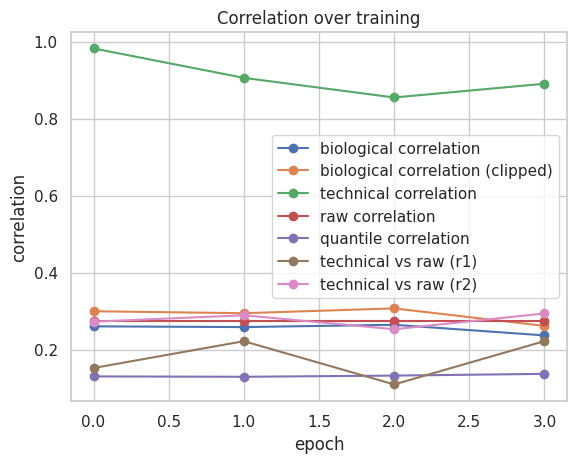

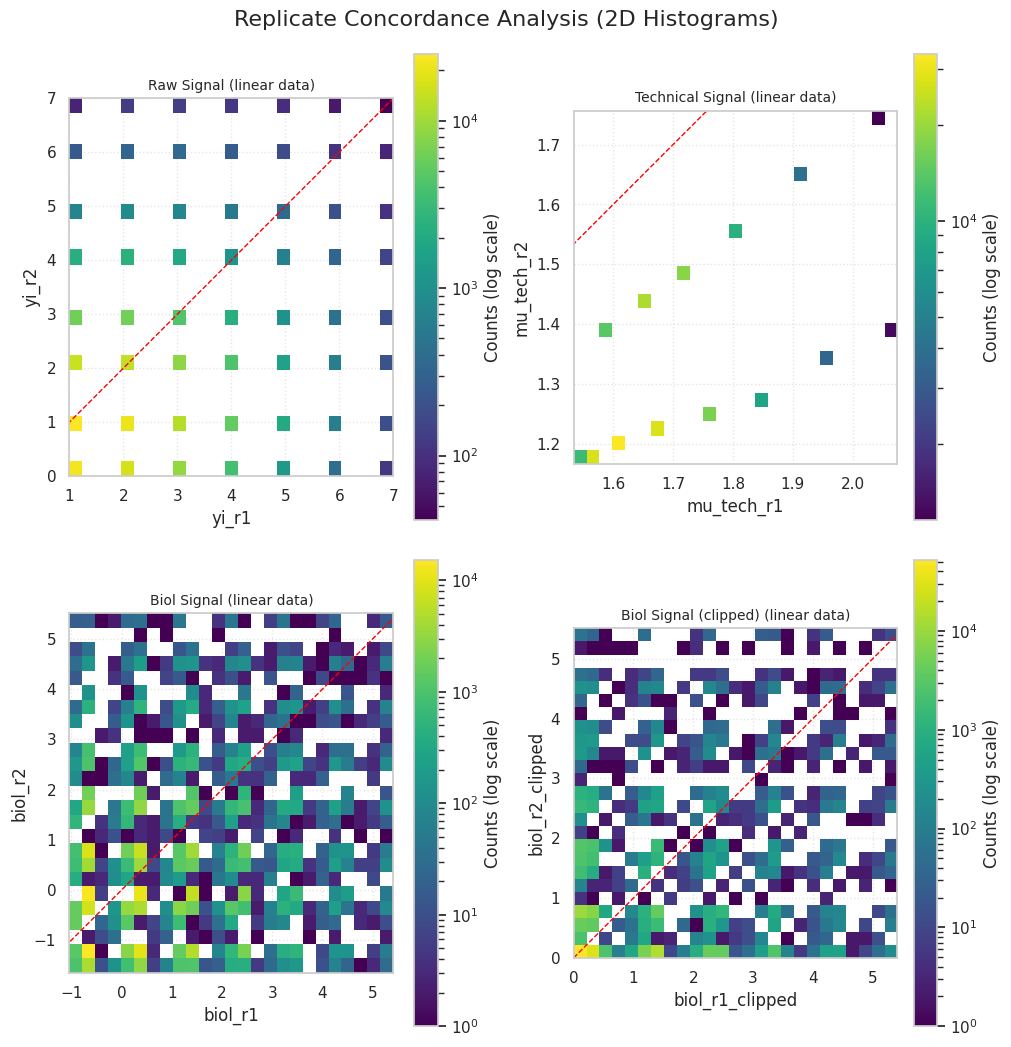

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2,quantile_r1,quantile_r2
0,1.645795,1.435429,0.354205,1.564571,2.0,3.0,1.0,0.999937,1.811243,0.999937,2.002470,1.0,0.999937,1.811243,0.999937,1.775615,0.771459,0.942199
1,1.645795,1.435429,0.354205,0.564571,2.0,2.0,1.0,0.999937,1.811243,0.999937,2.002470,1.0,0.999937,1.811243,0.999937,1.775615,0.771459,0.824872
2,1.719025,1.490296,-0.719025,-0.490296,1.0,1.0,2.0,0.999937,1.811243,0.999937,2.002470,2.0,0.999937,1.811243,0.999937,1.775615,0.510266,0.579664
3,2.041274,1.756890,-1.041274,-1.756890,1.0,0.0,5.0,0.999937,1.811243,0.999937,2.002470,5.0,0.999937,1.811243,1.000000,1.775615,0.510266,0.238013
4,2.041274,1.756901,-0.041274,-0.756901,2.0,1.0,5.0,0.999937,1.811243,0.999937,2.002470,5.0,0.999937,1.811243,0.999937,1.775615,0.771459,0.579664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673979,1.617180,1.194782,1.382820,0.805218,3.0,2.0,2.0,0.999369,2.591536,0.999478,1.842645,2.0,0.999369,2.591536,0.999332,1.233800,0.899057,0.869548
1673980,1.617191,1.194784,1.382809,0.805216,3.0,2.0,2.0,0.999369,2.591536,0.999390,1.842645,2.0,0.999369,2.591536,0.999292,1.233800,0.899057,0.869548
1673981,1.617202,1.194785,1.382798,0.805215,3.0,2.0,2.0,0.999343,2.591536,0.999325,1.842645,2.0,0.999343,2.591536,0.999292,1.233800,0.899057,0.869548
1673982,1.617195,1.194801,1.382805,0.805199,3.0,2.0,2.0,0.999048,2.591536,0.999673,1.842645,2.0,0.999048,2.591536,0.999266,1.233800,0.899057,0.869548


In [19]:
h3k_nb_all_3_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_all_3_nb_no_scaling"))
plot_df_2d_hist(h3k_nb_all_3_dfs[-1])
h3k_nb_all_3_dfs[-1]

In [29]:
h3k_nb_all_3_dfs[-1]["exp_sd_r2"].nunique()

2

Text(0.5, 1.0, 'Correlation over training')

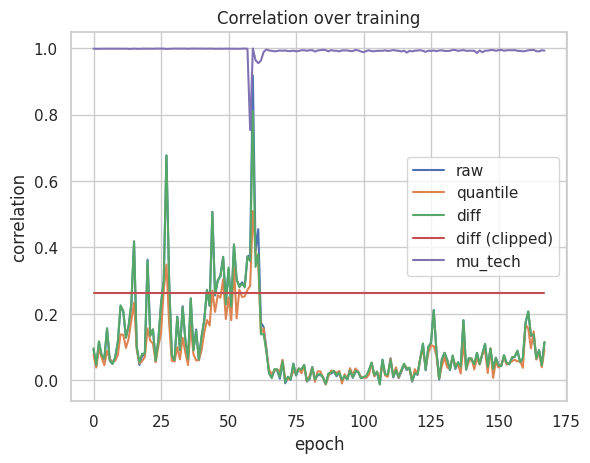

In [27]:
corrs_raw = []
corrs_quantile = []
corrs_diff = []
corrs_diff_clipped = []
corrs_mu_tech = []
for i in np.arange(0, len(h3k_nb_all_3_dfs[-1]), 10_000):
    stop = min(i + 10_000, len(h3k_nb_all_3_dfs[-1]))
    corrs_raw.append(np.corrcoef(h3k_nb_all_3_dfs[-1]["yi_r1"][i:stop], h3k_nb_all_3_dfs[-1]["yi_r2"][i:stop])[0][1])
    corrs_quantile.append(np.corrcoef(h3k_nb_all_3_dfs[-1]["quantile_r1"][i:stop], h3k_nb_all_3_dfs[-1]["quantile_r2"][i:stop])[0][1])
    corrs_diff.append(np.corrcoef(h3k_nb_all_3_dfs[-1]["mu1_r1_diff"][i:stop], h3k_nb_all_3_dfs[-1]["mu2_r2_diff"][i:stop])[0][1])
    corrs_diff_clipped.append(np.corrcoef(h3k_nb_all_3_dfs[-1]["mu1_r1_diff"].clip(lower=0, upper=None), h3k_nb_all_3_dfs[-1]["mu2_r2_diff"].clip(lower=0, upper=None))[0][1])
    corrs_mu_tech.append(np.corrcoef(h3k_nb_all_3_dfs[-1]["mu_tech_r1"][i:stop], h3k_nb_all_3_dfs[-1]["mu_tech_r2"][i:stop])[0][1])
plt.plot(corrs_raw, label="raw")
plt.plot(corrs_quantile, label="quantile")
plt.plot(corrs_diff, label="diff")
plt.plot(corrs_diff_clipped, label="diff (clipped)")
plt.plot(corrs_mu_tech, label="mu_tech")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("correlation")
plt.title("Correlation over training")


  1%|          | 1/100 [00:03<04:57,  3.01s/it]

Loaded epoch 0


  2%|▏         | 2/100 [00:05<04:53,  2.99s/it]

Loaded epoch 1


  3%|▎         | 3/100 [00:08<04:46,  2.95s/it]

Loaded epoch 2


  4%|▍         | 4/100 [00:12<05:03,  3.16s/it]

Loaded epoch 3


Subsampling dataframe from 1,756,288 to 200,000 rows for plotting speed.

Outlier removal for columns ['yi_r1', 'yi_r2']:
  • yi_r1        kept range [1.000, 17.000]
  • yi_r2        kept range [0.000, 26.000]
  → Dropped 1,637 / 200,000 rows (0.82%)
  → Remaining: 198,363 rows


Outlier removal for columns ['mu_tech_r1', 'mu_tech_r2']:
  • mu_tech_r1   kept range [1.223, 5.974]
  • mu_tech_r2   kept range [1.712, 14.981]
  → Dropped 1,616 / 200,000 rows (0.81%)
  → Remaining: 198,384 rows


Outlier removal for columns ['biol_r1', 'biol_r2']:
  • biol_r1      kept range [-3.594, 14.697]
  • biol_r2      kept range [-5.981, 18.122]
  → Dropped 3,419 / 200,000 rows (1.71%)
  → Remaining: 196,581 rows


Outlier removal for columns ['biol_r1_clipped', 'biol_r2_clipped']:
  • biol_r1_clipped kept range [0.000, 14.697]
  • biol_r2_clipped kept range [0.000, 18.122]
  → Dropped 1,572 / 200,000 rows (0.79%)
  → Remaining: 198,428 rows



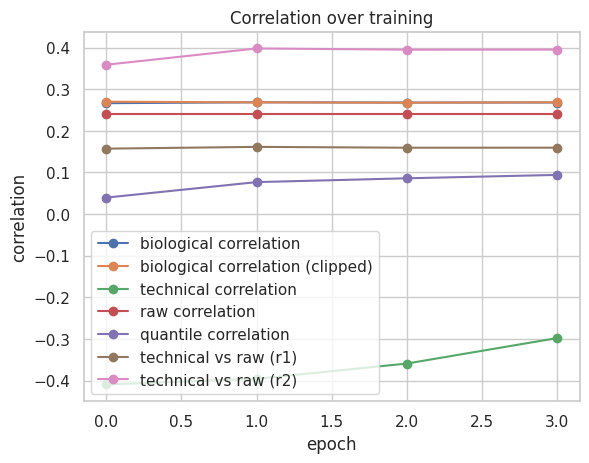

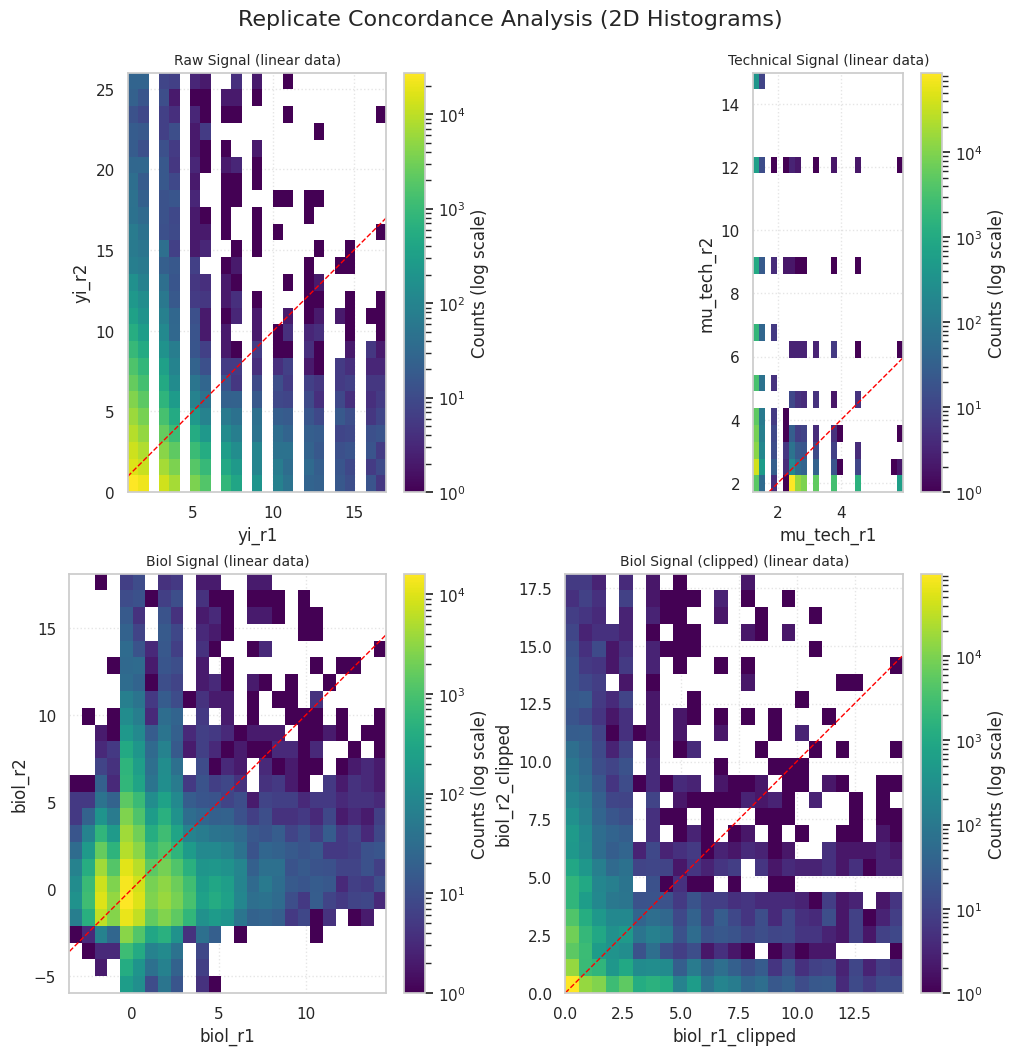

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,ctrl_reads_r1,ctrl_mapq_r1,ctrl_sd_r1,exp_mapq_r1,exp_sd_r1,ctrl_reads_r2,ctrl_mapq_r2,ctrl_sd_r2,exp_mapq_r2,exp_sd_r2,quantile_r1,quantile_r2
0,1.247324,2.631381,-0.247324,1.368619,1.0,4.0,2.0,0.999937,2.109393,0.999937,1.199963,3.0,0.999937,3.888930,0.999937,5.596734,0.645594,0.872948
1,1.303640,2.631381,-0.303640,-0.631381,1.0,2.0,4.0,0.999937,2.109393,0.999937,1.199963,3.0,0.999937,3.888930,0.999937,5.596734,0.645594,0.510580
2,1.446481,2.631381,-0.446481,-0.631381,1.0,2.0,6.0,0.999937,2.109393,0.999937,1.199963,3.0,0.999937,3.888930,0.999937,5.596734,0.645594,0.510580
3,1.247324,5.302582,-0.247324,-1.302582,1.0,4.0,2.0,0.999937,2.109393,0.999937,1.199963,7.0,0.999937,3.888930,0.999937,5.596734,0.645594,0.872948
4,1.247324,5.302582,0.752676,0.697418,2.0,6.0,2.0,0.999937,2.109393,0.999937,1.199963,7.0,0.999937,3.888930,0.999937,5.596734,0.869066,0.981809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756283,2.418119,1.725645,-1.418119,-0.725645,1.0,1.0,1.0,0.999369,2.758586,0.999206,2.629396,1.0,0.999369,2.591536,0.999684,1.793976,0.174167,0.479581
1756284,2.389274,1.725519,-1.389274,-1.725519,1.0,0.0,0.0,1.000000,2.758586,0.999000,2.629396,1.0,0.999749,2.591536,1.000000,1.793976,0.174167,0.174749
1756285,2.389274,1.725519,-1.389274,-1.725519,1.0,0.0,0.0,1.000000,2.758586,0.999000,2.629396,1.0,0.999749,2.591536,1.000000,1.793976,0.174167,0.174749
1756286,2.389274,1.725519,-1.389274,-1.725519,1.0,0.0,0.0,1.000000,2.758586,0.999000,2.629396,1.0,0.999749,2.591536,1.000000,1.793976,0.174167,0.174749


In [20]:
ctcf_nb_all_3_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/ctcf/run_all_3_nb_no_scaling"))
plot_df_2d_hist(ctcf_nb_all_3_dfs[-1])
ctcf_nb_all_3_dfs[-1]

In [5]:
h3k_nb_scaled_small_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_all_3_nb_scaled_small"))
plot_df_2d_hist(h3k_nb_scaled_small_dfs[-1])
h3k_nb_scaled_small_dfs[-1]

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Length of values (0) does not match length of index (1673728)

In [6]:
with open("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_all_3_nb_scaled_small/val_r1_tech_val_r1_0.npy", "rb") as f:
    print(np.load(f))


[]


In [ ]:
ctcf_nb_all_3_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/ctcf/run_all_3_nb_no_scaling"))
plot_df_2d_hist(ctcf_nb_all_3_dfs[-1])
ctcf_nb_all_3_dfs[-1]

100%|██████████| 176/176 [00:01<00:00, 132.23it/s]


Loaded epoch 0


100%|██████████| 176/176 [00:01<00:00, 89.33it/s] 


Loaded epoch 1


100%|██████████| 176/176 [00:01<00:00, 160.93it/s]


Loaded epoch 2


100%|██████████| 176/176 [00:01<00:00, 159.57it/s]


Loaded epoch 3


100%|██████████| 176/176 [00:01<00:00, 106.49it/s]


Loaded epoch 4


100%|██████████| 176/176 [00:01<00:00, 116.38it/s]


Loaded epoch 5


100%|██████████| 176/176 [00:01<00:00, 129.60it/s]


Loaded epoch 6


100%|██████████| 176/176 [00:01<00:00, 111.19it/s]


Loaded epoch 7


100%|██████████| 176/176 [00:01<00:00, 146.74it/s]


Loaded epoch 8


100%|██████████| 176/176 [00:01<00:00, 156.27it/s]


Loaded epoch 9


100%|██████████| 176/176 [00:01<00:00, 93.76it/s]


Loaded epoch 10


100%|██████████| 176/176 [00:01<00:00, 95.50it/s] 


Loaded epoch 11


100%|██████████| 176/176 [00:01<00:00, 147.59it/s]


Loaded epoch 12


100%|██████████| 176/176 [00:01<00:00, 106.19it/s]


Loaded epoch 13


100%|██████████| 176/176 [00:01<00:00, 92.01it/s] 


Loaded epoch 14


100%|██████████| 176/176 [00:01<00:00, 88.86it/s] 


Loaded epoch 15


100%|██████████| 176/176 [00:01<00:00, 152.59it/s]


Loaded epoch 16


100%|██████████| 176/176 [00:01<00:00, 142.45it/s]


Loaded epoch 17


100%|██████████| 176/176 [00:01<00:00, 105.25it/s]


Loaded epoch 18


100%|██████████| 176/176 [00:01<00:00, 162.14it/s]


Loaded epoch 19


100%|██████████| 176/176 [00:01<00:00, 99.09it/s] 


Loaded epoch 20


100%|██████████| 176/176 [00:01<00:00, 129.67it/s]


Loaded epoch 21


100%|██████████| 176/176 [00:01<00:00, 125.73it/s]


Loaded epoch 22


100%|██████████| 176/176 [00:01<00:00, 97.00it/s] 


Loaded epoch 23


100%|██████████| 176/176 [00:01<00:00, 149.11it/s]


Loaded epoch 24


100%|██████████| 176/176 [00:01<00:00, 122.13it/s]


Loaded epoch 25


100%|██████████| 176/176 [00:01<00:00, 149.33it/s]


Loaded epoch 26


100%|██████████| 176/176 [00:01<00:00, 127.67it/s]


Loaded epoch 27


100%|██████████| 176/176 [00:02<00:00, 85.53it/s] 


Loaded epoch 28


100%|██████████| 176/176 [00:01<00:00, 134.42it/s]


Loaded epoch 29


100%|██████████| 176/176 [00:01<00:00, 143.27it/s]


Loaded epoch 30


100%|██████████| 176/176 [00:01<00:00, 99.24it/s] 


Loaded epoch 31


100%|██████████| 176/176 [00:01<00:00, 121.32it/s]


Loaded epoch 32


100%|██████████| 176/176 [00:01<00:00, 138.38it/s]


Loaded epoch 33


100%|██████████| 176/176 [00:01<00:00, 104.47it/s]


Loaded epoch 34


100%|██████████| 176/176 [00:01<00:00, 152.65it/s]


Loaded epoch 35


100%|██████████| 176/176 [00:01<00:00, 108.71it/s]


Loaded epoch 36


100%|██████████| 176/176 [00:01<00:00, 100.08it/s]


Loaded epoch 37


100%|██████████| 176/176 [00:01<00:00, 111.31it/s]


Loaded epoch 38


100%|██████████| 176/176 [00:01<00:00, 125.77it/s]


Loaded epoch 39


100%|██████████| 176/176 [00:01<00:00, 131.66it/s]


Loaded epoch 40


100%|██████████| 176/176 [00:01<00:00, 91.96it/s] 


Loaded epoch 41


100%|██████████| 176/176 [00:01<00:00, 135.49it/s]


Loaded epoch 42


100%|██████████| 176/176 [00:01<00:00, 120.16it/s]


Loaded epoch 43


100%|██████████| 176/176 [00:01<00:00, 100.44it/s]


Loaded epoch 44


100%|██████████| 176/176 [00:01<00:00, 130.62it/s]


Loaded epoch 45


100%|██████████| 176/176 [00:01<00:00, 110.67it/s]


Loaded epoch 46


100%|██████████| 176/176 [00:01<00:00, 136.62it/s]


Loaded epoch 47


100%|██████████| 176/176 [00:01<00:00, 145.23it/s]


Loaded epoch 48


100%|██████████| 176/176 [00:01<00:00, 96.30it/s] 


Loaded epoch 49


100%|██████████| 176/176 [00:01<00:00, 153.17it/s]


Loaded epoch 50


100%|██████████| 176/176 [00:01<00:00, 107.12it/s]


Loaded epoch 51
Subsampling dataframe from 1,756,160 to 200,000 rows for plotting speed.

Outlier removal for columns ['yi_r1', 'yi_r2']:
  • yi_r1        kept range [1.000, 18.000]
  • yi_r2        kept range [0.000, 27.000]
  → Dropped 1,624 / 200,000 rows (0.81%)
  → Remaining: 198,376 rows


Outlier removal for columns ['mu_tech_r1', 'mu_tech_r2']:
  • mu_tech_r1   kept range [1.153, 4.415]
  • mu_tech_r2   kept range [1.610, 15.158]
  → Dropped 2,467 / 200,000 rows (1.23%)
  → Remaining: 197,533 rows


Outlier removal for columns ['biol_r1', 'biol_r2']:
  • biol_r1      kept range [-2.415, 15.594]
  • biol_r2      kept range [-5.638, 19.797]
  → Dropped 3,529 / 200,000 rows (1.76%)
  → Remaining: 196,471 rows


Outlier removal for columns ['biol_r1_clipped', 'biol_r2_clipped']:
  • biol_r1_clipped kept range [0.000, 15.594]
  • biol_r2_clipped kept range [0.000, 19.797]
  → Dropped 1,595 / 200,000 rows (0.80%)
  → Remaining: 198,405 rows



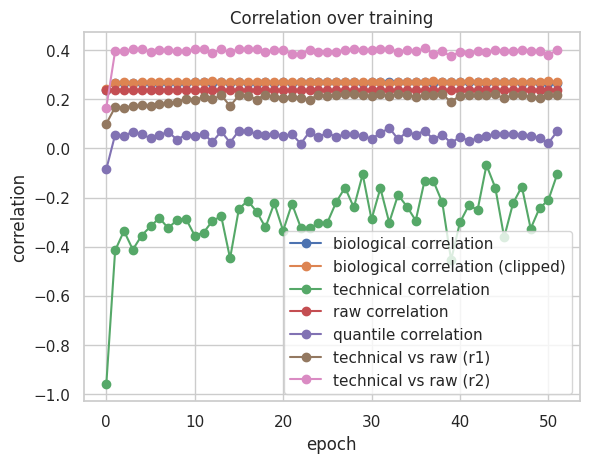

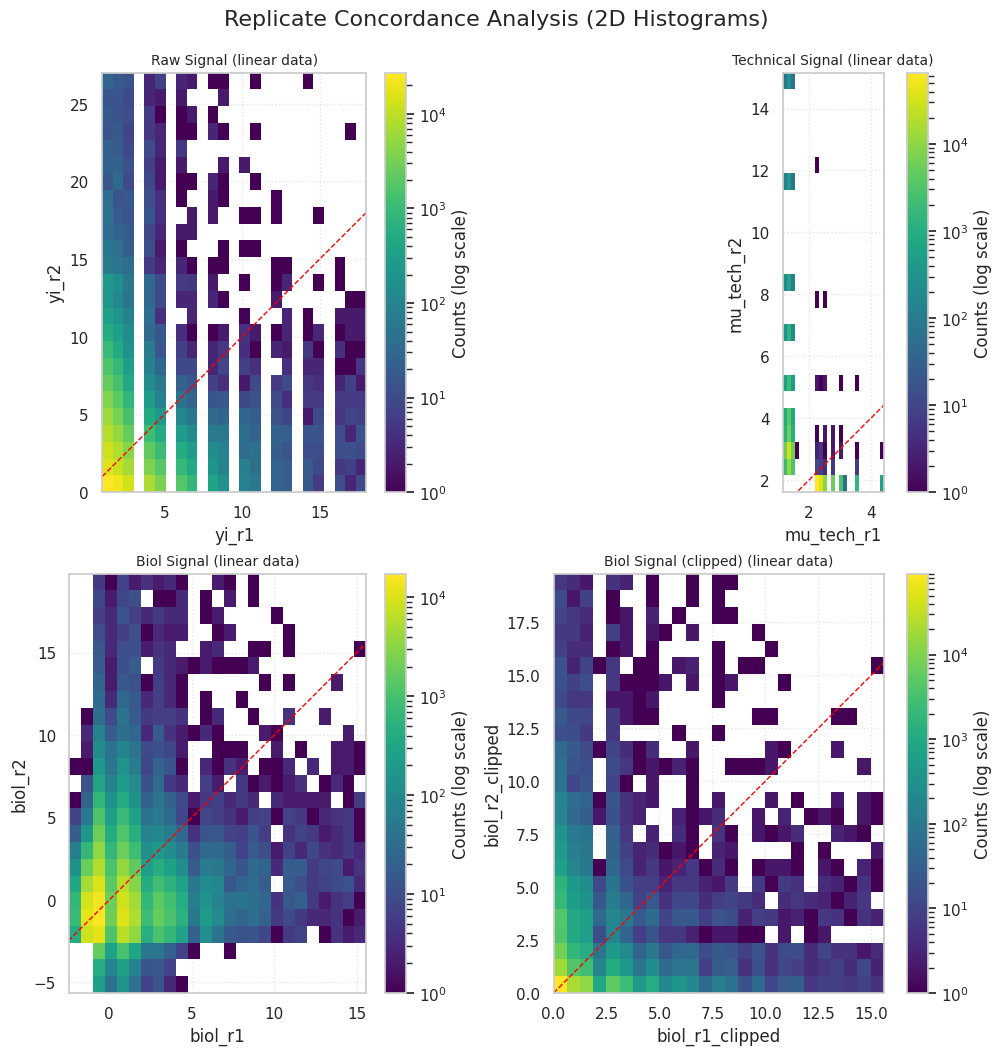

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2,quantile_r1,quantile_r2
0,1.352567,2.912522,-0.352567,1.087478,1.0,4.0,0.608316,0.829742
1,1.246675,2.912522,-0.246675,-0.912522,1.0,2.0,0.608316,0.443072
2,1.152829,2.912522,-0.152829,-0.912522,1.0,2.0,0.608316,0.443072
3,1.352567,5.169258,-0.352567,-1.169258,1.0,4.0,0.608316,0.829742
4,1.352567,5.169258,0.647433,0.830742,2.0,6.0,0.844840,0.970710
...,...,...,...,...,...,...,...,...
1756155,2.277628,1.662281,-1.277628,-0.662281,1.0,1.0,0.233639,0.477941
1756156,2.362263,1.662250,-1.362263,0.337750,1.0,2.0,0.233639,0.744025
1756157,2.309797,1.749844,-1.309797,1.250156,1.0,3.0,0.233639,0.899222
1756158,2.446055,1.750035,-1.446055,-0.750035,1.0,1.0,0.233639,0.477941


In [13]:
ctcf_all_3_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/ctcf/run_all_3_no_biol_scaling"))
plot_df_2d_hist(ctcf_all_3_dfs[-1])
ctcf_all_3_dfs[-1]

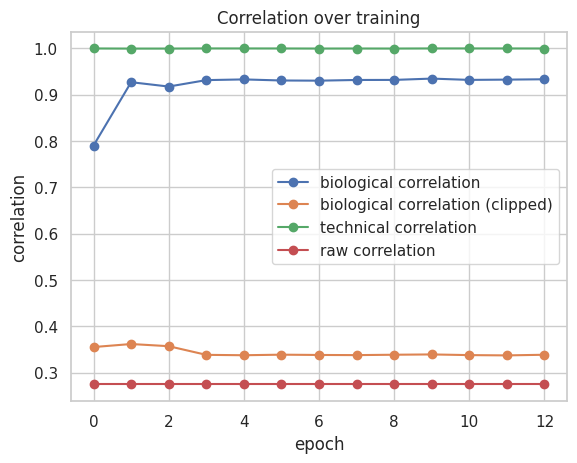

In [85]:
r3_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_3"))

In [86]:
for df in r3_dfs:
    display(df.head(10))

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,6.732964,6.569373,-4.732964,-6.337832,2.0,3.0
1,6.732964,6.569373,-4.732964,-8.113447,2.0,2.0
2,6.724933,6.593224,-5.724933,-9.931412,1.0,1.0
3,6.721846,6.597355,-5.721846,-11.714361,1.0,0.0
4,6.721846,6.597209,-4.721846,-9.938488,2.0,1.0
5,6.721846,6.597209,-3.721846,-9.938488,3.0,1.0
6,6.720401,6.601942,-3.720401,-9.946891,3.0,1.0
7,6.732964,6.569373,-3.732964,-9.889062,3.0,1.0
8,6.732964,6.569524,-4.732964,-11.664944,2.0,0.0
9,6.742894,6.520786,-5.742894,-11.578404,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.047194,9.758596,-9.047194,-12.000664,2.0,3.0
1,11.047194,9.758596,-9.047194,-13.776279,2.0,2.0
2,10.981784,9.841393,-9.981784,-15.698908,1.0,1.0
3,10.822117,10.011656,-9.822117,-17.776844,1.0,0.0
4,10.822117,10.010990,-8.822117,-16.000048,2.0,1.0
5,10.822117,10.010990,-7.822117,-16.000048,3.0,1.0
6,10.869187,9.965708,-7.869187,-15.919644,3.0,1.0
7,11.047194,9.758596,-8.047194,-15.551894,3.0,1.0
8,11.047194,9.759267,-9.047194,-17.328699,2.0,0.0
9,11.117600,9.660643,-10.117600,-17.153580,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.215705,8.848454,-9.215705,-10.384603,2.0,3.0
1,11.215705,8.848454,-9.215705,-12.160217,2.0,2.0
2,11.228652,8.762591,-10.228652,-13.783373,1.0,1.0
3,11.287388,8.404690,-10.287388,-14.923492,1.0,0.0
4,11.287388,8.403940,-9.287388,-13.146546,2.0,1.0
5,11.287388,8.403940,-8.287388,-13.146546,3.0,1.0
6,11.266106,8.538304,-8.266106,-13.385125,3.0,1.0
7,11.215705,8.848454,-8.215705,-13.935832,3.0,1.0
8,11.215705,8.849165,-9.215705,-15.712708,2.0,0.0
9,11.208279,8.915562,-10.208279,-15.830604,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.317521,9.618752,-9.317521,-11.752356,2.0,3.0
1,11.317521,9.618752,-9.317521,-13.527970,2.0,2.0
2,11.316638,9.616083,-10.316638,-15.298845,1.0,1.0
3,11.308328,9.630303,-10.308328,-17.099710,1.0,0.0
4,11.308328,9.629543,-9.308328,-15.322745,2.0,1.0
5,11.308328,9.629543,-8.308328,-15.322745,3.0,1.0
6,11.312236,9.620994,-8.312236,-15.307565,3.0,1.0
7,11.317521,9.618752,-8.317521,-15.303585,3.0,1.0
8,11.317521,9.619521,-9.317521,-17.080564,2.0,0.0
9,11.317448,9.625644,-10.317448,-17.091436,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.644354,9.579934,-9.644354,-11.683429,2.0,3.0
1,11.644354,9.579934,-9.644354,-13.459044,2.0,2.0
2,11.655093,9.546921,-10.655093,-15.176040,1.0,1.0
3,11.682692,9.466126,-10.682692,-16.808195,1.0,0.0
4,11.682692,9.465323,-9.682692,-15.031154,2.0,1.0
5,11.682692,9.465323,-8.682692,-15.031154,3.0,1.0
6,11.674392,9.489109,-8.674392,-15.073388,3.0,1.0
7,11.644354,9.579934,-8.644354,-15.234658,3.0,1.0
8,11.644354,9.580729,-9.644354,-17.011686,2.0,0.0
9,11.632743,9.616530,-10.632743,-17.075254,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.333554,9.558420,-9.333554,-11.645228,2.0,3.0
1,11.333554,9.558420,-9.333554,-13.420843,2.0,2.0
2,11.311728,9.601091,-10.311728,-15.272225,1.0,1.0
3,11.238034,9.745061,-10.238034,-17.303474,1.0,0.0
4,11.238034,9.744333,-9.238034,-15.526568,2.0,1.0
5,11.238034,9.744333,-8.238034,-15.526568,3.0,1.0
6,11.264134,9.693793,-8.264134,-15.436829,3.0,1.0
7,11.333554,9.558420,-8.333554,-15.196458,3.0,1.0
8,11.333554,9.559163,-9.333554,-16.973392,2.0,0.0
9,11.353969,9.519280,-10.353969,-16.902576,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.621297,9.392111,-9.621297,-11.349927,2.0,3.0
1,11.621297,9.392111,-9.621297,-13.125542,2.0,2.0
2,11.651076,9.301992,-10.651076,-14.741141,1.0,1.0
3,11.728199,9.041103,-10.728199,-16.053518,1.0,0.0
4,11.728199,9.040301,-9.728199,-14.276479,2.0,1.0
5,11.728199,9.040301,-8.728199,-14.276479,3.0,1.0
6,11.704638,9.125544,-8.704638,-14.427835,3.0,1.0
7,11.621297,9.392111,-8.621297,-14.901156,3.0,1.0
8,11.621297,9.392903,-9.621297,-16.678179,2.0,0.0
9,11.589437,9.484305,-10.589437,-16.840473,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.659023,9.494049,-9.659023,-11.530930,2.0,3.0
1,11.659023,9.494049,-9.659023,-13.306545,2.0,2.0
2,11.683469,9.421747,-10.683469,-14.953779,1.0,1.0
3,11.748825,9.216138,-10.748825,-16.364311,1.0,0.0
4,11.748825,9.215321,-9.748825,-14.587245,2.0,1.0
5,11.748825,9.215321,-8.748825,-14.587245,3.0,1.0
6,11.728478,9.281844,-8.728478,-14.705365,3.0,1.0
7,11.659023,9.494049,-8.659023,-15.082160,3.0,1.0
8,11.659023,9.494842,-9.659023,-16.859182,2.0,0.0
9,11.633168,9.568761,-10.633168,-16.990435,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.530159,9.524402,-9.530159,-11.584825,2.0,3.0
1,11.530159,9.524402,-9.530159,-13.360439,2.0,2.0
2,11.492595,9.604528,-10.492595,-15.278329,1.0,1.0
3,11.366325,9.852643,-10.366325,-17.494499,1.0,0.0
4,11.366325,9.851887,-9.366325,-15.717542,2.0,1.0
5,11.366325,9.851887,-8.366325,-15.717542,3.0,1.0
6,11.410746,9.768141,-8.410746,-15.568841,3.0,1.0
7,11.530159,9.524402,-8.530159,-15.136054,3.0,1.0
8,11.530159,9.525181,-9.530159,-16.913054,2.0,0.0
9,11.565262,9.446716,-10.565262,-16.773729,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.262410,10.077085,-9.262410,-12.566178,2.0,3.0
1,11.262410,10.077085,-9.262410,-14.341793,2.0,2.0
2,11.267731,10.058455,-10.267731,-16.084326,1.0,1.0
3,11.282928,10.013664,-10.282928,-17.780411,1.0,0.0
4,11.282928,10.012912,-9.282928,-16.003460,2.0,1.0
5,11.282928,10.012912,-8.282928,-16.003460,3.0,1.0
6,11.278270,10.025749,-8.278270,-16.026255,3.0,1.0
7,11.262410,10.077085,-8.262410,-16.117409,3.0,1.0
8,11.262410,10.077826,-9.262410,-17.894337,2.0,0.0
9,11.257014,10.097863,-10.257014,-17.929916,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.422221,9.602788,-9.422221,-11.724009,2.0,3.0
1,11.422221,9.602788,-9.422221,-13.499623,2.0,2.0
2,11.426685,9.584444,-10.426685,-15.242666,1.0,1.0
3,11.438161,9.543878,-10.438161,-16.946251,1.0,0.0
4,11.438161,9.543100,-9.438161,-15.169256,2.0,1.0
5,11.438161,9.543100,-8.438161,-15.169256,3.0,1.0
6,11.434845,9.554034,-8.434845,-15.188670,3.0,1.0
7,11.422221,9.602788,-8.422221,-15.275238,3.0,1.0
8,11.422221,9.603562,-9.422221,-17.052229,2.0,0.0
9,11.417427,9.623960,-10.417427,-17.088446,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.638971,9.540079,-9.638971,-11.612661,2.0,3.0
1,11.638971,9.540079,-9.638971,-13.388276,2.0,2.0
2,11.649682,9.503675,-10.649682,-15.099251,1.0,1.0
3,11.678991,9.411105,-10.678991,-16.710499,1.0,0.0
4,11.678991,9.410289,-9.678991,-14.933434,2.0,1.0
5,11.678991,9.410289,-8.678991,-14.933434,3.0,1.0
6,11.669903,9.438018,-8.669903,-14.982670,3.0,1.0
7,11.638971,9.540079,-8.638971,-15.163892,3.0,1.0
8,11.638971,9.540884,-9.638971,-16.940935,2.0,0.0
9,11.627857,9.579386,-10.627857,-17.009300,1.0,0.0


,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.481974,9.778019,-9.481974,-12.035151,2.0,3.0
1,11.481974,9.778019,-9.481974,-13.810766,2.0,2.0
2,11.507001,9.716013,-10.507001,-15.476282,1.0,1.0
3,11.575642,9.547485,-10.575642,-16.952658,1.0,0.0
4,11.575642,9.546691,-9.575642,-15.175632,2.0,1.0
5,11.575642,9.546691,-8.575642,-15.175632,3.0,1.0
6,11.554131,9.599363,-8.554131,-15.269157,3.0,1.0
7,11.481974,9.778019,-8.481974,-15.586381,3.0,1.0
8,11.481974,9.778794,-9.481974,-17.363373,2.0,0.0
9,11.456079,9.842636,-10.456079,-17.476730,1.0,0.0


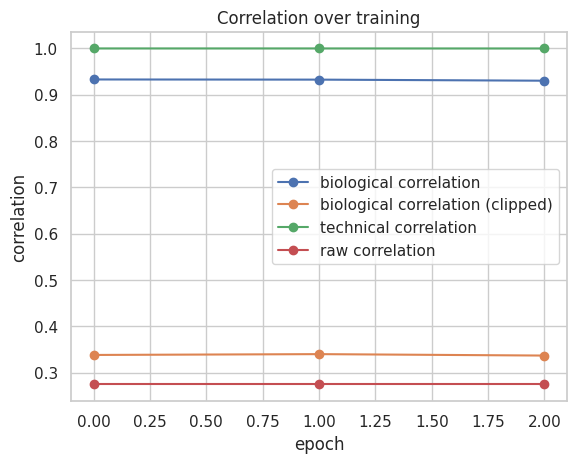

In [91]:
r4_dfs = run_analysis(Path("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_4"))

In [92]:
r4_dfs[-1]

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.394734,9.428039,-9.394734,-11.413721,2.0,3.0
1,11.394734,9.428039,-9.394734,-13.189336,2.0,2.0
2,11.414577,9.371669,-10.414577,-14.864860,1.0,1.0
3,11.469426,9.214475,-10.469426,-16.361359,1.0,0.0
4,11.469426,9.213658,-9.469426,-14.584293,2.0,1.0
...,...,...,...,...,...,...
1673979,1.523370,1.333333,1.476630,0.822534,3.0,2.0
1673980,1.523345,1.333330,1.476655,0.822537,3.0,2.0
1673981,1.523318,1.333329,1.476682,0.822539,3.0,2.0
1673982,1.523334,1.333310,1.476666,0.822562,3.0,2.0


In [95]:
with open("/lotterlab/users/abdul/repos/chipvi/runs/gpu/h3k27me3/run_4/val_xi_val_r1_0.npy", "rb") as f:
    x_r1 = np.load(f)

x_r1

array([[1.        , 0.9999369 , 1.8112426 , 0.9999369 , 2.0024695 ],
       [1.        , 0.9999369 , 1.8112426 , 0.9999369 , 2.0024695 ],
       [2.        , 0.9999369 , 1.8112426 , 0.9999369 , 2.0024695 ],
       ...,
       [2.        , 0.99934286, 2.5915356 , 0.9993245 , 1.8426452 ],
       [2.        , 0.9990481 , 2.5915356 , 0.9996732 , 1.8426452 ],
       [1.        , 0.999     , 2.5915356 , 0.9997488 , 1.8426452 ]],
      dtype=float32)

In [96]:
x_r1.shape

(1673984, 5)

In [103]:
np.mean(r4_dfs[0]["yi_r1"] - x_r1[:, 0])

0.04739173

(array([1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 1.10000e+01, 0.00000e+00,
        0.00000e+00, 1.60000e+01, 0.00000e+00, 0.00000e+00, 1.90000e+01,
        0.00000e+00, 0.00000e+00, 2.90000e+01, 0.00000e+00, 0.00000e+00,
        8.70000e+01, 0.00000e+00, 0.00000e+00, 1.79000e+02, 0.00000e+00,
        0.00000e+00, 4.99000e+02, 0.00000e+00, 0.00000e+00, 1.52400e+03,
        0.00000e+00, 0.00000e+00, 4.82800e+03, 0.00000e+00, 0.00000e+00,
        1.49260e+04, 0.00000e+00, 0.00000e+00, 4.02010e+04, 0.00000e+00,
        0.00000e+00, 9.40760e+04, 0.00000e+00, 0.00000e+00, 1.85669e+05,
        0.00000e+00, 0.00000e+00, 2.95434e+05, 0.00000e+00, 0.00000e+00,
        3.61909e+05, 0.00000e+00, 3.22241e+05, 0.00000e+00, 0.00000e+00,
        1.89052e+05, 0.00000e+00, 0.00000e+00, 9.33760e+04, 0.00000e+00,
        0.00000e+00, 4.09830e+04, 0.00000e+00, 0.00000e+00, 1.69600e+04,
        0.00000e+00, 0.00000e+00, 6.86800e+03, 0.00

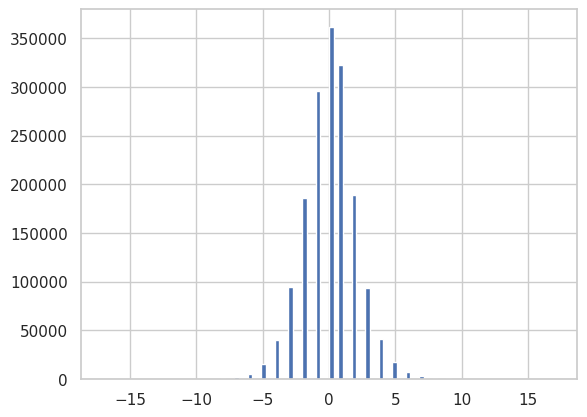

In [102]:
plt.hist(r4_dfs[0]["yi_r1"] - x_r1[:, 0], bins=100)

In [100]:
np.corrcoef(x_r1[:, 0], r4_dfs[0]["yi_r2"])

array([[1.        , 0.02363631],
       [0.02363631, 1.        ]])

In [98]:
x_r1[:, 0]

array([1., 1., 2., ..., 2., 2., 1.], dtype=float32)

In [84]:
r3_dfs[1]

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,11.047194,9.758596,-9.047194,-12.000664,2.0,3.0
1,11.047194,9.758596,-9.047194,-13.776279,2.0,2.0
2,10.981784,9.841393,-9.981784,-15.698908,1.0,1.0
3,10.822117,10.011656,-9.822117,-17.776844,1.0,0.0
4,10.822117,10.010990,-8.822117,-16.000048,2.0,1.0
...,...,...,...,...,...,...
1673979,1.853414,1.714230,1.146586,0.352583,3.0,2.0
1673980,1.853391,1.714228,1.146609,0.352586,3.0,2.0
1673981,1.853367,1.714227,1.146633,0.352587,3.0,2.0
1673982,1.853381,1.714212,1.146619,0.352606,3.0,2.0


In [33]:
val_df_0 = load_val_data(0)
display((val_df_0["mu1_r1_diff"] != 0).mean())
display((val_df_0["mu2_r2_diff"] != 0).mean())
display(val_df_0)

1.0

1.0

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,1.787944,1.544994,0.212056,2.583531,2.0,3.0
1,1.787944,1.544994,0.212056,0.807916,2.0,2.0
2,1.914694,1.649225,-0.914694,-1.152774,1.0,1.0
3,2.356920,2.012171,-1.356920,-3.572841,1.0,0.0
4,2.356920,2.012187,-0.356920,-1.797255,2.0,1.0
...,...,...,...,...,...,...
1673979,1.653958,1.147650,1.346042,1.051629,3.0,2.0
1673980,1.653974,1.147654,1.346026,1.051624,3.0,2.0
1673981,1.653991,1.147657,1.346009,1.051621,3.0,2.0
1673982,1.653979,1.147688,1.346021,1.051583,3.0,2.0


In [35]:
display(val_df_0[["yi_r1", "yi_r2"]].corr())

display(val_df_0[["mu1_r1_diff", "mu2_r2_diff"]].corr())

,yi_r1,yi_r2
yi_r1,1.000000,0.274468
yi_r2,0.274468,1.000000


,mu1_r1_diff,mu2_r2_diff
mu1_r1_diff,1.000000,0.251686
mu2_r2_diff,0.251686,1.000000


In [27]:
val_df_0.describe()

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
count,1.673984e+06,1.673984e+06,1.673984e+06,1.673984e+06,1.673984e+06,1.673984e+06
mean,1.772025e+00,1.325820e+00,4.579028e-01,2.261958e-01,2.229928e+00,1.457696e+00
std,2.229586e-01,2.450742e-01,1.352589e+00,2.134396e+00,1.367933e+00,1.427315e+00
min,1.453390e+00,1.076791e+00,-6.330859e+00,-6.109914e+00,1.000000e+00,0.000000e+00
25%,1.653777e+00,1.147533e+00,-6.537769e-01,-1.370387e+00,1.000000e+00,0.000000e+00
50%,1.762631e+00,1.224349e+00,2.373683e-01,-1.820264e-01,2.000000e+00,1.000000e+00
75%,1.876732e+00,1.544994e+00,1.237084e+00,1.051774e+00,3.000000e+00,2.000000e+00
max,1.773153e+01,1.624421e+01,1.412070e+02,1.694631e+02,1.490000e+02,1.460000e+02


In [21]:
val_df_1 = load_val_data(1)
display((val_df_1["mu1_r1_diff"] != 0).mean())
display((val_df_1["mu2_r2_diff"] != 0).mean())
display(val_df_1)

1.0

1.0

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,1.642035,1.433776,0.357965,2.781010,2.0,3.0
1,1.642035,1.433776,0.357965,1.005395,2.0,2.0
2,1.751874,1.525266,-0.751874,-0.932670,1.0,1.0
3,2.088074,1.794180,-1.088074,-3.185773,1.0,0.0
4,2.088074,1.794196,-0.088074,-1.410185,2.0,1.0
...,...,...,...,...,...,...
1673979,1.499712,1.100492,1.500288,1.109813,3.0,2.0
1673980,1.499727,1.100495,1.500273,1.109809,3.0,2.0
1673981,1.499743,1.100497,1.500257,1.109807,3.0,2.0
1673982,1.499731,1.100523,1.500269,1.109775,3.0,2.0


In [23]:
val_df_2 = load_val_data(2)
display((val_df_2["mu1_r1_diff"] != 0).mean())
display((val_df_2["mu2_r2_diff"] != 0).mean())
display(val_df_2)

1.0

1.0

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,1.589165,1.384686,0.410835,2.868175,2.0,3.0
1,1.589165,1.384686,0.410835,1.092560,2.0,2.0
2,1.710240,1.485255,-0.710240,-0.861626,1.0,1.0
3,2.097261,1.800222,-1.097261,-3.196500,1.0,0.0
4,2.097261,1.800239,-0.097261,-1.420917,2.0,1.0
...,...,...,...,...,...,...
1673979,1.466853,1.066976,1.533147,1.151165,3.0,2.0
1673980,1.466870,1.066980,1.533130,1.151160,3.0,2.0
1673981,1.466887,1.066982,1.533113,1.151157,3.0,2.0
1673982,1.466874,1.067011,1.533126,1.151122,3.0,2.0


In [22]:
val_df_2 = load_val_data(2)
display((val_df_2["mu1_r1_diff"] != 0).mean())
display((val_df_2["mu2_r2_diff"] != 0).mean())
display(val_df_2)

1.0

1.0

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,1.589165,1.384686,0.410835,2.868175,2.0,3.0
1,1.589165,1.384686,0.410835,1.092560,2.0,2.0
2,1.710240,1.485255,-0.710240,-0.861626,1.0,1.0
3,2.097261,1.800222,-1.097261,-3.196500,1.0,0.0
4,2.097261,1.800239,-0.097261,-1.420917,2.0,1.0
...,...,...,...,...,...,...
1673979,1.466853,1.066976,1.533147,1.151165,3.0,2.0
1673980,1.466870,1.066980,1.533130,1.151160,3.0,2.0
1673981,1.466887,1.066982,1.533113,1.151157,3.0,2.0
1673982,1.466874,1.067011,1.533126,1.151122,3.0,2.0


In [11]:
val_df_3 = load_val_data(3)
display((val_df_3["mu1_r1_diff"] != 0).mean())
display((val_df_3["mu2_r2_diff"] != 0).mean())
display(val_df_3)

1.0

1.0

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,2.229766,1.769576,-0.229766,2.184759,2.0,3.0
1,2.229766,1.769576,-0.229766,0.409144,2.0,2.0
2,1.757122,1.446645,-0.757122,-0.793070,1.0,1.0
3,2.188140,1.905041,-1.188140,-3.382618,1.0,0.0
4,2.188140,1.905059,-0.188140,-1.607037,2.0,1.0
...,...,...,...,...,...,...
1673979,1.564564,1.104524,1.435436,1.104839,3.0,2.0
1673980,1.564614,1.104534,1.435386,1.104827,3.0,2.0
1673981,1.564665,1.104540,1.435335,1.104819,3.0,2.0
1673982,1.564630,1.104620,1.435370,1.104720,3.0,2.0


In [12]:
val_df_4 = load_val_data(4)
display((val_df_4["mu1_r1_diff"] != 0).mean())
display((val_df_4["mu2_r2_diff"] != 0).mean())
display(val_df_4)

1.0

1.0

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,2.482316,1.931182,-0.482316,1.897809,2.0,3.0
1,2.482316,1.931182,-0.482316,0.122194,2.0,2.0
2,1.788135,1.457883,-0.788135,-0.813024,1.0,1.0
3,2.026227,1.778602,-1.026227,-3.158112,1.0,0.0
4,2.026227,1.778618,-0.026227,-1.382527,2.0,1.0
...,...,...,...,...,...,...
1673979,1.567537,1.088202,1.432463,1.124977,3.0,2.0
1673980,1.567587,1.088212,1.432413,1.124964,3.0,2.0
1673981,1.567639,1.088218,1.432361,1.124956,3.0,2.0
1673982,1.567603,1.088299,1.432397,1.124857,3.0,2.0


In [13]:
val_df_5 = load_val_data(5)
display((val_df_5["mu1_r1_diff"] != 0).mean())
display((val_df_5["mu2_r2_diff"] != 0).mean())
display(val_df_5)

1.0

1.0

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,2.262307,1.781359,-0.262307,2.163838,2.0,3.0
1,2.262307,1.781359,-0.262307,0.388223,2.0,2.0
2,1.757719,1.430249,-0.757719,-0.763957,1.0,1.0
3,2.037024,1.796184,-1.037024,-3.189331,1.0,0.0
4,2.037024,1.796201,-0.037024,-1.413746,2.0,1.0
...,...,...,...,...,...,...
1673979,1.555176,1.053507,1.444824,1.167784,3.0,2.0
1673980,1.555227,1.053517,1.444773,1.167771,3.0,2.0
1673981,1.555279,1.053524,1.444721,1.167763,3.0,2.0
1673982,1.555242,1.053606,1.444758,1.167661,3.0,2.0


In [ ]:
def visualize():
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(100):
        

In [14]:
epoch_dfs = []
for i in range(100):
    try:
        epoch_dfs.append(load_val_data(i))
    except FileNotFoundError:
        break

100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


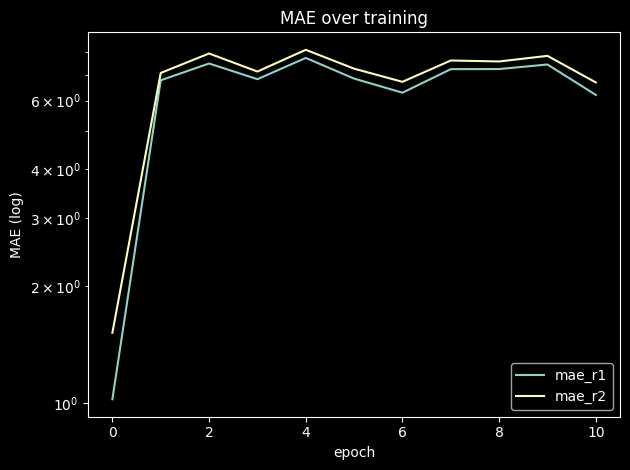

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def epoch_summary(df):
    return {
        "mae_r1":  (df["mu1_r1_diff"]).abs().mean(),
        "mae_r2":  (df["mu2_r2_diff"]).abs().mean(),
        "mse_r1":  (df["mu1_r1_diff"]**2).mean(),
        "mse_r2":  (df["mu2_r2_diff"]**2).mean(),
        "pearson_r1": df[["mu_tech_r1", "yi_r1"]].corr().iloc[0, 1],
        "pearson_r2": df[["mu_tech_r2", "yi_r2"]].corr().iloc[0, 1],
    }

stats = pd.DataFrame([epoch_summary(df) | {"epoch": i}
                      for i, df in enumerate(tqdm(epoch_dfs))])

plt.figure()
for col in ["mae_r1", "mae_r2"]:
    plt.plot(stats["epoch"], stats[col], label=col)
plt.yscale("log");  plt.xlabel("epoch");  plt.ylabel("MAE (log)")
plt.legend();  plt.title("MAE over training");  plt.tight_layout()

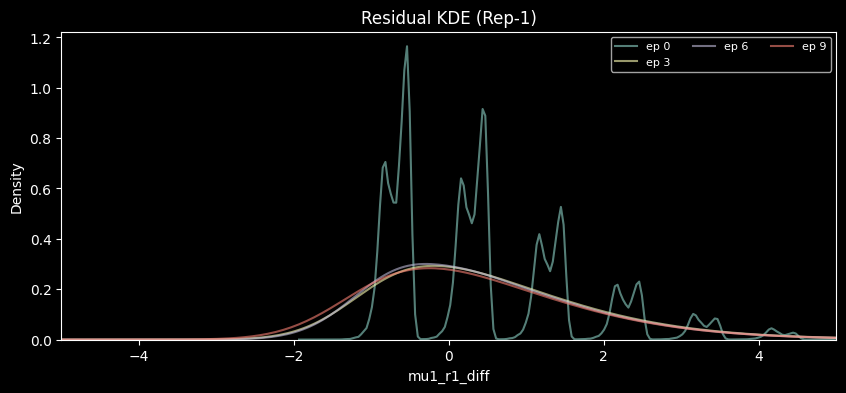

In [16]:
import seaborn as sns    # <‑‑ only for easy violin/KDE; drop‑in replace with matplotlib if you prefer

sample_every = 3          # thin epochs so the plot isn’t unreadable
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(0, len(epoch_dfs), sample_every):
    sns.kdeplot(epoch_dfs[i]["mu1_r1_diff"], ax=ax,
                label=f"ep {i}", bw_adjust=0.5, alpha=0.6, clip=(-5, 5))
ax.set_xlim(-5, 5); ax.set_title("Residual KDE (Rep‑1)")
ax.legend(ncol=3, fontsize=8)

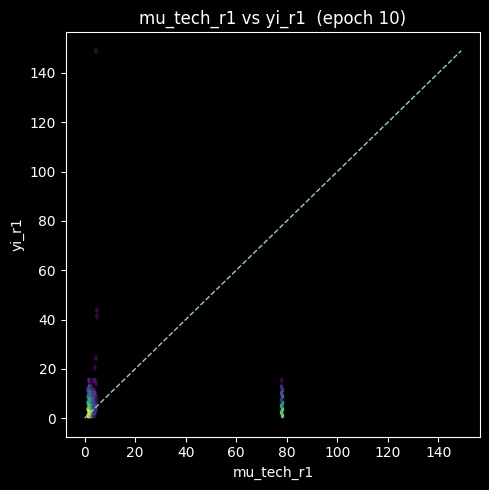

In [17]:
def scatter_hex(df, col_pred, col_obs, *, epoch, N=200_000):
    df_sub = df.sample(min(N, len(df)), random_state=42)
    plt.figure(figsize=(5,5))
    plt.hexbin(df_sub[col_pred], df_sub[col_obs], gridsize=100, bins="log")
    plt.plot([0, df_sub[[col_pred, col_obs]].values.max()],
             [0, df_sub[[col_pred, col_obs]].values.max()],
             ls="--", lw=1)
    plt.xlabel(col_pred); plt.ylabel(col_obs)
    plt.title(f"{col_pred} vs {col_obs}  (epoch {epoch})")
    plt.tight_layout()

scatter_hex(epoch_dfs[-1], "mu_tech_r1", "yi_r1", epoch=len(epoch_dfs)-1)

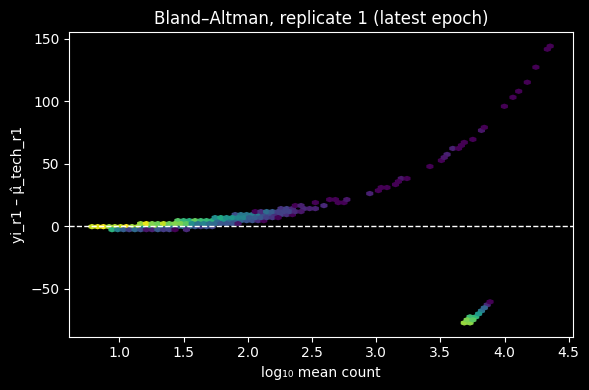

In [18]:
import numpy as np
df = epoch_dfs[-1]   # latest epoch
mean_counts = 0.5*(df["mu_tech_r1"] + df["yi_r1"])
diff        = df["mu1_r1_diff"]

plt.figure(figsize=(6,4))
plt.hexbin(np.log1p(mean_counts), diff, gridsize=80, bins="log")
plt.axhline(0, ls="--", lw=1)
plt.xlabel("log₁₀ mean count")
plt.ylabel("yi_r1 – μ̂_tech_r1")
plt.title("Bland–Altman, replicate 1 (latest epoch)")
plt.tight_layout()

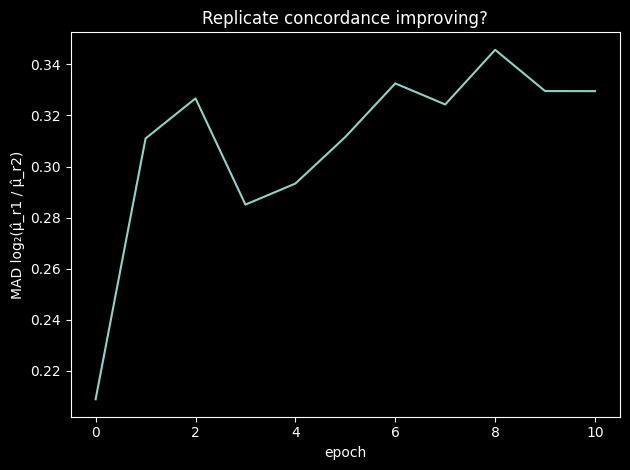

In [19]:
import numpy as np
import matplotlib.pyplot as plt

concord = []
for i, df in enumerate(epoch_dfs):
    # log ratio of technical means after depth scaling
    lr = np.log2( (df["mu_tech_r1"] + 1) / (df["mu_tech_r2"] + 1) )
    concord.append({"epoch": i, "mad_log2_ratio": np.median(np.abs(lr))})

concord = pd.DataFrame(concord)
plt.figure()
plt.plot(concord["epoch"], concord["mad_log2_ratio"])
plt.xlabel("epoch"); plt.ylabel("MAD log₂(μ̂_r1 / μ̂_r2)")
plt.title("Replicate concordance improving?")
plt.tight_layout()

In [40]:
df[["mu1_r1_diff", "mu2_r2_diff"]].corr()

,mu1_r1_diff,mu2_r2_diff
mu1_r1_diff,1.000000,0.993609
mu2_r2_diff,0.993609,1.000000


In [39]:
df

,mu_tech_r1,mu_tech_r2,mu1_r1_diff,mu2_r2_diff,yi_r1,yi_r2
0,2.280604,1.776218,-0.280604,2.172965,2.0,3.0
1,2.280604,1.776218,-0.280604,0.397351,2.0,2.0
2,1.754416,1.432470,-0.754416,-0.767900,1.0,1.0
3,2.058532,1.831058,-1.058532,-3.251254,1.0,0.0
4,2.058532,1.831075,-0.058532,-1.475669,2.0,1.0
...,...,...,...,...,...,...
1673979,1.657429,1.078587,1.342571,1.136840,3.0,2.0
1673980,1.657490,1.078598,1.342510,1.136825,3.0,2.0
1673981,1.657553,1.078607,1.342447,1.136815,3.0,2.0
1673982,1.657517,1.078709,1.342483,1.136689,3.0,2.0


In [38]:
np.corrcoef(df["mu1_r1_diff"], df["mu2_r2_diff"])

array([[1.       , 0.9936086],
       [0.9936086, 1.       ]])

In [45]:
epoch_dfs_new = []
for i in range(100):
    try:
        epoch_dfs_new.append(load_val_data(i))
    except FileNotFoundError:
        break
epoch_dfs_new

[         mu_tech_r1  mu_tech_r2  mu1_r1_diff  mu2_r2_diff  yi_r1  yi_r2
 0          1.787944    1.544994     0.212056     2.583531    2.0    3.0
 1          1.787944    1.544994     0.212056     0.807916    2.0    2.0
 2          1.914694    1.649225    -0.914694    -1.152774    1.0    1.0
 3          2.356920    2.012171    -1.356920    -3.572841    1.0    0.0
 4          2.356920    2.012187    -0.356920    -1.797255    2.0    1.0
 ...             ...         ...          ...          ...    ...    ...
 1673979    1.653958    1.147650     1.346042     1.051629    3.0    2.0
 1673980    1.653974    1.147654     1.346026     1.051624    3.0    2.0
 1673981    1.653991    1.147657     1.346009     1.051621    3.0    2.0
 1673982    1.653979    1.147688     1.346021     1.051583    3.0    2.0
 1673983    1.550235    1.110782     1.449765    -1.370483    3.0    0.0
 
 [1673984 rows x 6 columns],
          mu_tech_r1  mu_tech_r2  mu1_r1_diff  mu2_r2_diff  yi_r1  yi_r2
 0          1.642035

In [42]:
len(epoch_dfs)

11

Text(0.5, 1.0, 'Correlation over training')

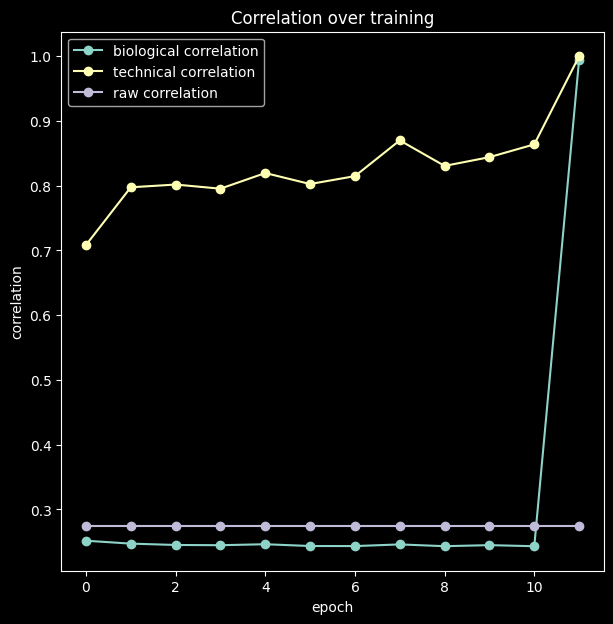

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

biol_corrs = [np.corrcoef(df["mu1_r1_diff"], df["mu2_r2_diff"])[0][1] for df in epoch_dfs_new]
tech_corrs = [np.corrcoef(df["mu_tech_r1"], df["mu_tech_r2"])[0][1] for df in epoch_dfs_new]
raw_corrs = [np.corrcoef(df["yi_r1"], df["yi_r2"])[0][1] for df in epoch_dfs_new]

ax.plot(biol_corrs, label="biological correlation", marker="o")
ax.plot(tech_corrs, label="technical correlation", marker="o")
ax.plot(raw_corrs, label="raw correlation", marker="o")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("correlation")
ax.set_title("Correlation over training")